<a href="https://colab.research.google.com/github/fyansyarafa/weekly-sales-forecasting/blob/master/src/forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Peramalan Penjualan Mingguan (Weekly Sales) PT ABCD

## Starter Code

In [ ]:
import statsmodels
statsmodels.__version__

'0.10.2'

In [ ]:
import statsmodels
from statsmodels.graphics.tsaplots import month_plot, quarter_plot

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display_html
from itertools import chain,cycle
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
from scipy.stats import chi2_contingency
from scipy import stats
from plotly.subplots import make_subplots
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import statsmodels.api as sm
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 


pio.templates.default = "plotly_white"

In [ ]:
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/Narasio Data/Senior Data Scientist Learning Course/Milestone Project/Time Series Forecasting/data/Time_Series.csv'

In [ ]:
df = pd.read_csv(path)

## 1. Tentang Data

In [ ]:
df.head()

Store  Dept       Date  Weekly_Sales  ...         CPI  Unemployment  Type    Size
0      1     1   2/5/2010      24924.50  ...  211.096358         8.106     A  151315
1      1     1  2/12/2010      46039.49  ...  211.242170         8.106     A  151315
2      1     1  2/19/2010      41595.55  ...  211.289143         8.106     A  151315
3      1     1  2/26/2010      19403.54  ...  211.319643         8.106     A  151315
4      1     1   3/5/2010      21827.90  ...  211.350143         8.106     A  151315

[5 rows x 11 columns]

### 1.1. Deskripsi Kasus

Salah satu perusahaan besar ritel multinasional Amerika yang berkantor pusat di Bentonville, PT ABCD, mengoperasikan jaringan hypermarket, department store, diskon, dan toko grosir. PT ABCD memiliki banyak toko di seluruh dunia dan merupakan perusahaan ritel terbesar berdasarkan pendapatan.

PT ABCD memiliki 5 toko besar yang tersebar di beberapa benua, di mana di setiap store terdapat banyak department store, dan anda akan mendapatkan data dari toko-toko ini. Selain itu, data mingguan harga bahan bakar, hari libur, suhu, dan beberapa fitur lainnya juga akan ada di kumpulan data. Fitur-fitur ini dianggap berpengaruh dengan pengingkatan atau penurunan sales week.

### 1.2. Tujuan

PT ABCD menjalankan beberapa acara penurunan harga promosi sepanjang tahun. Penurunan harga ini mendahului hari libur terkemuka, empat terbesar di antaranya adalah Super Bowl, Hari Buruh, Thanksgiving, dan Natal. Dengan adanya peningkatan penjualan pada saat itu.

Kini, PT ABCD ingin melakukan prediksi beberapa minggu ke depan apakah penjualannya turun atau naik, dengan melihat agregat seluruh store

## 2. Data Preprocessing

Tabel deskrpisi fitur:

In [ ]:
desc = [
        'Nama Toko',
        'Nomor departemen toko',
        'Tanggal hari Jumat setiap minggu',
        'Hasil penjualan setiap minggu',
        'Apakah minggu ini adalah minggu libur khusus?',
        'Rata-rata suhu di region (F)',
        'Biaya bahan bakar di region',
        'Indeks Harga Konsumen (Consumer Price Index)',
        'Tingkat Pengangguran',
        'Tipe toko',
        'Ukuran toko'
]

desc = pd.DataFrame(
    index = df.columns,
    data = desc,
    columns = ['Desc']
)

In [ ]:
desc

Desc
Store                                             Nama Toko
Dept                                  Nomor departemen toko
Date                       Tanggal hari Jumat setiap minggu
Weekly_Sales                  Hasil penjualan setiap minggu
IsHoliday     Apakah minggu ini adalah minggu libur khusus?
Temperature                    Rata-rata suhu di region (F)
Fuel_Price                      Biaya bahan bakar di region
CPI            Indeks Harga Konsumen (Consumer Price Index)
Unemployment                           Tingkat Pengangguran
Type                                              Tipe toko
Size                                            Ukuran toko

Sebagai contoh, berikut ini cara memanggil tabel berdasarkan pilihan fitur tertentu. Misalnya, untuk fitur `Store` dan `IsHoliday`:

In [ ]:
desc.loc['Store']

Desc    Nama Toko
Name: Store, dtype: object

In [ ]:
desc.loc['IsHoliday']

Desc    Apakah minggu ini adalah minggu libur khusus?
Name: IsHoliday, dtype: object

### 2.1. Mengecek Kesesuaian Tipe Data Untuk Masing-Masing Fitur

In [ ]:
df.head()

Store  Dept       Date  Weekly_Sales  ...         CPI  Unemployment  Type    Size
0      1     1   2/5/2010      24924.50  ...  211.096358         8.106     A  151315
1      1     1  2/12/2010      46039.49  ...  211.242170         8.106     A  151315
2      1     1  2/19/2010      41595.55  ...  211.289143         8.106     A  151315
3      1     1  2/26/2010      19403.54  ...  211.319643         8.106     A  151315
4      1     1   3/5/2010      21827.90  ...  211.350143         8.106     A  151315

[5 rows x 11 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48789 entries, 0 to 48788
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         48789 non-null  int64  
 1   Dept          48789 non-null  int64  
 2   Date          48789 non-null  object 
 3   Weekly_Sales  48789 non-null  float64
 4   IsHoliday     48789 non-null  bool   
 5   Temperature   48789 non-null  float64
 6   Fuel_Price    48789 non-null  float64
 7   CPI           48789 non-null  float64
 8   Unemployment  48789 non-null  float64
 9   Type          48789 non-null  object 
 10  Size          48789 non-null  int64  
dtypes: bool(1), float64(5), int64(3), object(2)
memory usage: 3.8+ MB


Seluruh fitur telah memiliki tipe data yang sesuai. Tetapi, fitur `Date` masih memiliki tipe data `object`. Fitur ini seharunya memiliki tipe data `datetime`, karena berisikan informasi mengenai waktu. Oleh karena itu, fitur ini akan diubah tipe datanya menjadi `datetime`.

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48789 entries, 0 to 48788
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         48789 non-null  int64         
 1   Dept          48789 non-null  int64         
 2   Date          48789 non-null  datetime64[ns]
 3   Weekly_Sales  48789 non-null  float64       
 4   IsHoliday     48789 non-null  bool          
 5   Temperature   48789 non-null  float64       
 6   Fuel_Price    48789 non-null  float64       
 7   CPI           48789 non-null  float64       
 8   Unemployment  48789 non-null  float64       
 9   Type          48789 non-null  object        
 10  Size          48789 non-null  int64         
dtypes: bool(1), datetime64[ns](1), float64(5), int64(3), object(1)
memory usage: 3.8+ MB


In [ ]:
df.head()

Store  Dept       Date  Weekly_Sales  ...         CPI  Unemployment  Type    Size
0      1     1 2010-02-05      24924.50  ...  211.096358         8.106     A  151315
1      1     1 2010-02-12      46039.49  ...  211.242170         8.106     A  151315
2      1     1 2010-02-19      41595.55  ...  211.289143         8.106     A  151315
3      1     1 2010-02-26      19403.54  ...  211.319643         8.106     A  151315
4      1     1 2010-03-05      21827.90  ...  211.350143         8.106     A  151315

[5 rows x 11 columns]

### 2.2. Klasifikasi Tipe Variabel/Fitur

Pada bagian ini, dilakukan klasifikasi mengenai tipe dari variabel/fitur dari data yang telah dimiliki. Klasifikasi ini berguna agar fitur-fitur pada tabel dapat dikenali berdasarkan jenis variabelnya, seperti:

- Kategorik

- Numerik
  - Diskrit 
  - Kontinu.


Dengan mengklasifikasikan variabel ke dalam kelas-kelas di atas, tentunya akan lebih mudah untuk memberikan penanganan yang tepat berdasarkan karakteristik masing-masing kelas di atas.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48789 entries, 0 to 48788
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         48789 non-null  int64         
 1   Dept          48789 non-null  int64         
 2   Date          48789 non-null  datetime64[ns]
 3   Weekly_Sales  48789 non-null  float64       
 4   IsHoliday     48789 non-null  bool          
 5   Temperature   48789 non-null  float64       
 6   Fuel_Price    48789 non-null  float64       
 7   CPI           48789 non-null  float64       
 8   Unemployment  48789 non-null  float64       
 9   Type          48789 non-null  object        
 10  Size          48789 non-null  int64         
dtypes: bool(1), datetime64[ns](1), float64(5), int64(3), object(1)
memory usage: 3.8+ MB


In [ ]:
df.head()

Store  Dept       Date  Weekly_Sales  ...         CPI  Unemployment  Type    Size
0      1     1 2010-02-05      24924.50  ...  211.096358         8.106     A  151315
1      1     1 2010-02-12      46039.49  ...  211.242170         8.106     A  151315
2      1     1 2010-02-19      41595.55  ...  211.289143         8.106     A  151315
3      1     1 2010-02-26      19403.54  ...  211.319643         8.106     A  151315
4      1     1 2010-03-05      21827.90  ...  211.350143         8.106     A  151315

[5 rows x 11 columns]

Jumlah *unique values* untuk masing-masing fitur:

In [ ]:
desc

Desc
Store                                             Nama Toko
Dept                                  Nomor departemen toko
Date                       Tanggal hari Jumat setiap minggu
Weekly_Sales                  Hasil penjualan setiap minggu
IsHoliday     Apakah minggu ini adalah minggu libur khusus?
Temperature                    Rata-rata suhu di region (F)
Fuel_Price                      Biaya bahan bakar di region
CPI            Indeks Harga Konsumen (Consumer Price Index)
Unemployment                           Tingkat Pengangguran
Type                                              Tipe toko
Size                                            Ukuran toko

In [ ]:
nunique = []
for i in df.columns:
  nunique.append(df[i].nunique())

df_nunique = pd.DataFrame(
    index=df.columns,
    data = nunique,
    columns=['Jumlah Unique Values']
)

In [ ]:
desc['Jumlah Unique Values'] = df_nunique['Jumlah Unique Values']

In [ ]:
desc

Desc  Jumlah Unique Values
Store                                             Nama Toko                     5
Dept                                  Nomor departemen toko                    78
Date                       Tanggal hari Jumat setiap minggu                   143
Weekly_Sales                  Hasil penjualan setiap minggu                 46330
IsHoliday     Apakah minggu ini adalah minggu libur khusus?                     2
Temperature                    Rata-rata suhu di region (F)                   675
Fuel_Price                      Biaya bahan bakar di region                   248
CPI            Indeks Harga Konsumen (Consumer Price Index)                   715
Unemployment                           Tingkat Pengangguran                    60
Type                                              Tipe toko                     2
Size                                            Ukuran toko                     5

In [ ]:
len(df)

48789

Daftar *unique values* untuk masing-masing fiturnya:

In [ ]:
for i in df.columns:
  print(i)
  print(df[i].unique())
  print('\n')


Store
[1 2 3 4 5]


Dept
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 40 41 42 44 45 46 47 48 49 51 52
 54 55 56 58 59 60 67 71 72 74 77 78 79 80 81 82 83 85 87 90 91 92 93 94
 95 96 97 98 99 39]


Date
['2010-02-05T00:00:00.000000000' '2010-02-12T00:00:00.000000000'
 '2010-02-19T00:00:00.000000000' '2010-02-26T00:00:00.000000000'
 '2010-03-05T00:00:00.000000000' '2010-03-12T00:00:00.000000000'
 '2010-03-19T00:00:00.000000000' '2010-03-26T00:00:00.000000000'
 '2010-04-02T00:00:00.000000000' '2010-04-09T00:00:00.000000000'
 '2010-04-16T00:00:00.000000000' '2010-04-23T00:00:00.000000000'
 '2010-04-30T00:00:00.000000000' '2010-05-07T00:00:00.000000000'
 '2010-05-14T00:00:00.000000000' '2010-05-21T00:00:00.000000000'
 '2010-05-28T00:00:00.000000000' '2010-06-04T00:00:00.000000000'
 '2010-06-11T00:00:00.000000000' '2010-06-18T00:00:00.000000000'
 '2010-06-25T00:00:00.000000000' '2010-07-02T00:00:00.000000000'
 '2010-07-09T0

In [ ]:
vartype = [
 'Categorical',
 'Categorical',
 'Categorical',
 'Continuous',
 'Categorical',
 'Continuous',
 'Continuous',
 'Continuous',
 'Continuous',
 'Categorical',
 'Categorical'
]

Secara lengkap, metadata yang dihasilkan adalah sebagai berikut.

In [ ]:
desc['vartype'] = vartype
desc

Desc  ...      vartype
Store                                             Nama Toko  ...  Categorical
Dept                                  Nomor departemen toko  ...  Categorical
Date                       Tanggal hari Jumat setiap minggu  ...  Categorical
Weekly_Sales                  Hasil penjualan setiap minggu  ...   Continuous
IsHoliday     Apakah minggu ini adalah minggu libur khusus?  ...  Categorical
Temperature                    Rata-rata suhu di region (F)  ...   Continuous
Fuel_Price                      Biaya bahan bakar di region  ...   Continuous
CPI            Indeks Harga Konsumen (Consumer Price Index)  ...   Continuous
Unemployment                           Tingkat Pengangguran  ...   Continuous
Type                                              Tipe toko  ...  Categorical
Size                                            Ukuran toko  ...  Categorical

[11 rows x 3 columns]

### 2.3. Cek Konsistensi Selisih Penganggalan 

Karena konteks yang diinginkan adalah penjualan di tiap minggunya, maka akan dicek konsistensi dari selisih waktu masing-masing minggunya. Dengan harapan, seluruh keterangan waktu pada dataframe utama seluruhnya memiliki selisih waktu 7 hari.

In [ ]:
pd.DataFrame(pd.Series(df['Date'].unique()).sort_values()).diff()

0
0      NaT
1   7 days
2   7 days
3   7 days
4   7 days
..     ...
138 7 days
139 7 days
140 7 days
141 7 days
142 7 days

[143 rows x 1 columns]

In [ ]:
pd.DataFrame(pd.Series(df['Date'].unique()).sort_values()).diff().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143 entries, 0 to 142
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype          
---  ------  --------------  -----          
 0   0       142 non-null    timedelta64[ns]
dtypes: timedelta64[ns](1)
memory usage: 2.2 KB


In [ ]:
pd.DataFrame(pd.Series(df['Date'].unique()).sort_values()).diff().value_counts()

7 days    142
dtype: int64

Seluruh penanggalan konsisten di 7 hari.

### 2.4 Missing Values

Pengecekan: 

In [ ]:
len(df)

48789

In [ ]:
df.isnull().sum().sort_values(ascending=False)

Size            0
Type            0
Unemployment    0
CPI             0
Fuel_Price      0
Temperature     0
IsHoliday       0
Weekly_Sales    0
Date            0
Dept            0
Store           0
dtype: int64

Tidak ada *missing values*.

###2.5. Data Redundan

In [ ]:
df.duplicated(keep=False)

0        False
1        False
2        False
3        False
4        False
         ...  
48784    False
48785    False
48786    False
48787    False
48788    False
Length: 48789, dtype: bool

In [ ]:
df.duplicated(keep=False).unique()

array([False])

### 2.6. Mengecek Kesesuaian Pola pada Fitur Date

In [ ]:
len(df['Date'].astype(str).str.contains('^\d{4}\-(0[1-9]|1[012])\-(0[1-9]|[12][0-9]|3[01])$'))

48789

In [ ]:
len(df)

48789

In [ ]:
df.head()

Store  Dept       Date  Weekly_Sales  ...         CPI  Unemployment  Type    Size
0      1     1 2010-02-05      24924.50  ...  211.096358         8.106     A  151315
1      1     1 2010-02-12      46039.49  ...  211.242170         8.106     A  151315
2      1     1 2010-02-19      41595.55  ...  211.289143         8.106     A  151315
3      1     1 2010-02-26      19403.54  ...  211.319643         8.106     A  151315
4      1     1 2010-03-05      21827.90  ...  211.350143         8.106     A  151315

[5 rows x 11 columns]

### 2.7. Pengurutan Data 

In [ ]:
df = df.sort_values(by=['Store','Date','Dept'])
df.head()

Store  Dept       Date  ...  Unemployment  Type    Size
0        1     1 2010-02-05  ...         8.106     A  151315
143      1     2 2010-02-05  ...         8.106     A  151315
286      1     3 2010-02-05  ...         8.106     A  151315
429      1     4 2010-02-05  ...         8.106     A  151315
572      1     5 2010-02-05  ...         8.106     A  151315

[5 rows x 11 columns]

###2.8. Pemisahan Dataframe Berdasarkan Kode Store

Dataframe baru yang dihasilkan adalah
- `df_store1`, untuk kode store 1
- `df_store2`, untuk kode store 2
- `df_store3`, untuk kode store 3
- `df_store4`, untuk kode store 4
- `df_store5`, untuk kode store 5

In [ ]:
for i in df['Store'].unique():
  locals()['df_store'+ str(i)] = df.loc[df['Store'] == i]

In [ ]:
df_store1.head()

Store  Dept       Date  ...  Unemployment  Type    Size
0        1     1 2010-02-05  ...         8.106     A  151315
143      1     2 2010-02-05  ...         8.106     A  151315
286      1     3 2010-02-05  ...         8.106     A  151315
429      1     4 2010-02-05  ...         8.106     A  151315
572      1     5 2010-02-05  ...         8.106     A  151315

[5 rows x 11 columns]

In [ ]:
df_store3.head()

Store  Dept       Date  ...  Unemployment  Type   Size
20482      3     1 2010-02-05  ...         7.368     B  37392
20625      3     2 2010-02-05  ...         7.368     B  37392
20768      3     3 2010-02-05  ...         7.368     B  37392
20911      3     4 2010-02-05  ...         7.368     B  37392
21054      3     5 2010-02-05  ...         7.368     B  37392

[5 rows x 11 columns]

In [ ]:
list_store = [df_store1, df_store2, df_store3, df_store4, df_store5]

## Pre-Exploratory Data Analysis

### 3.1. Pengelompokkan Jenis-Jenis Variabel

In [ ]:
desc

Desc  ...      vartype
Store                                             Nama Toko  ...  Categorical
Dept                                  Nomor departemen toko  ...  Categorical
Date                       Tanggal hari Jumat setiap minggu  ...  Categorical
Weekly_Sales                  Hasil penjualan setiap minggu  ...   Continuous
IsHoliday     Apakah minggu ini adalah minggu libur khusus?  ...  Categorical
Temperature                    Rata-rata suhu di region (F)  ...   Continuous
Fuel_Price                      Biaya bahan bakar di region  ...   Continuous
CPI            Indeks Harga Konsumen (Consumer Price Index)  ...   Continuous
Unemployment                           Tingkat Pengangguran  ...   Continuous
Type                                              Tipe toko  ...  Categorical
Size                                            Ukuran toko  ...  Categorical

[11 rows x 3 columns]

In [ ]:
df_continuous_desc = desc.loc[desc['vartype'] == 'Continuous']
df_catdis_desc = desc[desc['vartype'] == 'Categorical']

### 3.2. Hubungan antar Jenis Variabel

#### Numerik

In [ ]:
df_num_corr = df.groupby(['Date']).mean()

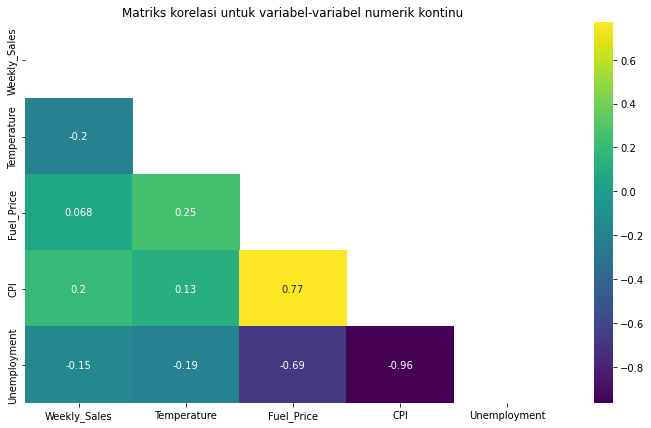

In [ ]:
df_continuous_a = df_num_corr[desc.loc[desc['vartype'] == 'Continuous'].index]
matrix = np.triu(df_continuous_a.corr())
plt.figure(figsize=(12,7))
sns.heatmap(df_continuous_a.corr(), annot=True, cmap='viridis', mask=matrix)
plt.title('Matriks korelasi untuk variabel-variabel numerik kontinu');

#### Kategorik

Akan dilakukan uji t statistics untuk membuktikan adanya hubungan antar variabel.
Hipotesis yang akan dibuktikan adalah
- H₀ (Null Hypothesis): 2 variabel kategorik yang dibandingkan adalah **independent (tidak saling terikat)**,
- H₁ (Alternate Hypothesis): 2 variabel kategorik yang dibandingkan adalah **dependent (saling terikat)**.

In [ ]:
var1 = []
var2 = []
p_value = []
boolean = []
relationships = []
for j in df[df_catdis_desc.index].columns:
  for i in df[df_catdis_desc.index].columns:
    if chi2_contingency(pd.crosstab(df[j], df[i]))[1] < 0.05:
      rel = 'Dependen'
    else:
      rel = 'Independen'
    var1.append(j)
    var2.append(i)
    p_value.append(chi2_contingency(pd.crosstab(df[j], df[i]))[1])
    boolean.append(chi2_contingency(pd.crosstab(df[j], df[i]))[1] < 0.05)
    relationships.append(rel)

df_catdis_rel = pd.DataFrame({
    'var1' : var1,
    'var2' : var2,
    'p_value' : p_value,
    'x < 0.05?' : boolean,
    'relationships' : relationships
})

df_cat_rel = df_catdis_rel[df_catdis_rel['var1'] != df_catdis_rel['var2']]

In [ ]:
df_cat_rel.loc[df_cat_rel['relationships']=='Dependen']

var1       var2        p_value  x < 0.05? relationships
1       Store       Dept  5.617189e-247       True      Dependen
4       Store       Type   0.000000e+00       True      Dependen
5       Store       Size   0.000000e+00       True      Dependen
6        Dept      Store  5.617189e-247       True      Dependen
10       Dept       Type   0.000000e+00       True      Dependen
11       Dept       Size  5.617189e-247       True      Dependen
15       Date  IsHoliday   0.000000e+00       True      Dependen
20  IsHoliday       Date   0.000000e+00       True      Dependen
24       Type      Store   0.000000e+00       True      Dependen
25       Type       Dept   0.000000e+00       True      Dependen
29       Type       Size   0.000000e+00       True      Dependen
30       Size      Store   0.000000e+00       True      Dependen
31       Size       Dept  5.617189e-247       True      Dependen
34       Size       Type   0.000000e+00       True      Dependen

In [ ]:
df_cat_rel.loc[df_cat_rel['relationships']=='Independen']

var1       var2   p_value  x < 0.05? relationships
2       Store       Date  1.000000      False    Independen
3       Store  IsHoliday  0.999145      False    Independen
8        Dept       Date  1.000000      False    Independen
9        Dept  IsHoliday  0.999996      False    Independen
12       Date      Store  1.000000      False    Independen
13       Date       Dept  1.000000      False    Independen
16       Date       Type  1.000000      False    Independen
17       Date       Size  1.000000      False    Independen
18  IsHoliday      Store  0.999145      False    Independen
19  IsHoliday       Dept  0.999996      False    Independen
22  IsHoliday       Type  0.998673      False    Independen
23  IsHoliday       Size  0.999145      False    Independen
26       Type       Date  1.000000      False    Independen
27       Type  IsHoliday  0.998673      False    Independen
32       Size       Date  1.000000      False    Independen
33       Size  IsHoliday  0.999145      False    Independen

## 3. Exploratory Data Analysis

### 4.1. Kondisi Umum Data

#### Histori Penjualan Mingguan

Pendapatan hasil penjualan selama hampir 3 tahun (143 minggu):

In [ ]:
fig_main_ws = make_subplots(rows = 1, cols=2, column_widths=[0.9, 0.1], subplot_titles=('Histogram', 'Boxplot'))

#histogram
fig_main_ws.add_trace(
    go.Histogram(x=df['Weekly_Sales'], nbinsx=200, showlegend=False,name='Weekly Sales'),
    row=1,col=1
)

#annot total pendapatan
fig_main_ws.add_trace(
    go.Scatter(
        x= [300000],
        y= [8000],
        text=["Total Pendapatan Penjualan = {}".format(round(df.Weekly_Sales.sum(),3))],
        mode='text',
        showlegend=False
    )
)

#vline
fig_main_ws.add_trace(
    go.Scatter(
        x= [df['Weekly_Sales'].median(), df['Weekly_Sales'].median()],
        y= [0, 12000],
        text=["Total Pendapatan Penjualan = {}".format(round(df.Weekly_Sales.sum(),3))],
        mode='lines',
        showlegend=True,
        name = 'Rata-rata pendapatan = {}'.format(df['Weekly_Sales'].median()),
        line=dict(width=2,
                  color='DarkSlateGrey',
                  dash='dot')
    )
)

#boxplot
fig_main_ws.add_trace(
    go.Box(y = df['Weekly_Sales'],showlegend=False, name='Weekly Sales'),
    row=1,
    col=2
)



#axes
fig_main_ws.update_yaxes(title_text="Jumlah Transaksi Penjualan", row=1, col=1)

fig_main_ws.update_xaxes(title_text="Pendapatan Mingguan ($)", row=1, col=1)



#layout
fig_main_ws.update_traces(opacity=1)
fig_main_ws.update_layout(barmode='overlay',
                                  title_text= 'Transaksi Penjualan Selama 143 Minggu',
                                  )


Rata-rata penjualan mingguan selama selang waktu 143 minggu:

In [ ]:
df_date_agg = df.groupby(['Date']).mean()[desc.loc[desc['vartype'] == 'Continuous'].index][['Weekly_Sales']]

In [ ]:
fig_history_ws = px.line(
    x = df_date_agg.index,
    y = df_date_agg['Weekly_Sales'],
    title = 'Rata-Rata Penjualan Mingguan dalam 143 Minggu'
)

fig_history_ws.show()

#### CPI dan Unemployment Rate

In [ ]:
df_date_agg_cpi_unem = df.groupby(['Date']).mean()[desc.loc[desc['vartype'] == 'Continuous'].index][['CPI','Unemployment']]

In [ ]:
fig_rate_CPI_Unem = make_subplots(rows=1, cols=2, shared_yaxes=False,subplot_titles=("Consumer Price Index Rate", "Unemployment Rate"))
fig_rate_CPI_Unem.add_trace(go.Scatter(x=df_date_agg_cpi_unem.index, y=df_date_agg_cpi_unem['CPI'], name='CPI',showlegend=False), row=1,col=1)
fig_rate_CPI_Unem.add_trace(go.Scatter(x=df_date_agg_cpi_unem.index, y=df_date_agg_cpi_unem['Unemployment'], name='Unempoloyment', marker_color='#636EFA',showlegend=False), row=1,col=2)
fig_rate_CPI_Unem.show()

#### Rata-Rata Penjualan Bulanan Perusahaan Year on Year

In [ ]:
df_date_agg['Month'] = pd.DatetimeIndex(df_date_agg.reset_index()['Date']).month
df_date_agg['Year'] = pd.DatetimeIndex(df_date_agg.reset_index()['Date']).year
df_date_agg_yoy = df_date_agg.groupby(['Month','Year']).median()[['Weekly_Sales']].reset_index()

In [ ]:
# filling blank entries per year type B
df_date_agg_yoy_2010 = pd.DataFrame(np.array([[1, 2010, 0]]), columns=['Month', 'Year', 'Weekly_Sales']).append(df_date_agg_yoy[df_date_agg_yoy['Year'] == 2010], ignore_index=True)
df_date_agg_yoy_2011 = df_date_agg_yoy[df_date_agg_yoy['Year'] == 2011]
df_date_agg_yoy_2012 = pd.DataFrame(np.array([[11,2012,0]]), columns=['Month', 'Year', 'Weekly_Sales']).append(df_date_agg_yoy[df_date_agg_yoy['Year'] == 2012], ignore_index=True)
df_date_agg_yoy_2012 = pd.DataFrame(np.array([[12,2012,0]]), columns=['Month', 'Year', 'Weekly_Sales']).append(df_date_agg_yoy, ignore_index=True)
df_date_agg_yoy_2012.sort_values(['Month', 'Year'], inplace=True)

In [ ]:
fig_yoy_all_monthly = go.Figure()

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig_yoy_all_monthly.add_trace(go.Bar(
    x=months,
    y=df_date_agg_yoy_2010[df_date_agg_yoy_2010['Year'] == 2010]['Weekly_Sales'],
    name='2010', legendgroup = '2010'
))
fig_yoy_all_monthly.add_trace(go.Bar(
    x=months,
    y=df_date_agg_yoy_2011[df_date_agg_yoy_2011['Year'] == 2011]['Weekly_Sales'],
    name='2011',legendgroup = '2011'
))
fig_yoy_all_monthly.add_trace(go.Bar(
    x=months,
    y=df_date_agg_yoy_2012[df_date_agg_yoy_2012['Year'] == 2012]['Weekly_Sales'],
    name='2012', legendgroup = '2012'
))


fig_yoy_all_monthly.update_layout(
                  title_text="Rata-Rata Penjualan Bulanan Year on Year",
                  legend_title_text='Tahun')
fig_yoy_all_monthly.show()

### 4.3. Penjualan Mingguan Masing-Masing Toko

#### Transaksi Penjualan Masing-Masing Toko

In [ ]:
df_store1_ws = df[df['Store'] == 1].groupby('Date').mean()[['Weekly_Sales']]
df_store2_ws = df[df['Store'] == 2].groupby('Date').mean()[['Weekly_Sales']]
df_store3_ws = df[df['Store'] == 3].groupby('Date').mean()[['Weekly_Sales']]
df_store4_ws = df[df['Store'] == 4].groupby('Date').mean()[['Weekly_Sales']]
df_store5_ws = df[df['Store'] == 5].groupby('Date').mean()[['Weekly_Sales']]

In [ ]:
df_store1_ws.head()

Weekly_Sales
Date                    
2010-02-05  22516.313699
2010-02-12  22804.964444
2010-02-19  22081.755753
2010-02-26  19579.549861
2010-03-05  21298.721644

In [ ]:
fig_transaksi_ws = make_subplots(rows=2, cols=3, subplot_titles=['Store 1','Store 2','Store 3','Store 4','Store 5'])

fig_transaksi_ws.add_trace(go.Histogram(x = df_store1['Weekly_Sales'], name='Store 1', showlegend=False, nbinsx=50),row=1, col=1)
fig_transaksi_ws.add_trace(go.Histogram(x = df_store2['Weekly_Sales'], name='Store 2', showlegend=False, nbinsx=50),row=1, col=2)
fig_transaksi_ws.add_trace(go.Histogram(x = df_store3['Weekly_Sales'], name='Store 3', showlegend=False, nbinsx=50),row=1, col=3)
fig_transaksi_ws.add_trace(go.Histogram(x = df_store4['Weekly_Sales'], name='Store 4', showlegend=False, nbinsx=50),row=2, col=1)
fig_transaksi_ws.add_trace(go.Histogram(x = df_store5['Weekly_Sales'], name='Store 5', showlegend=False, nbinsx=50),row=2, col=2)
fig_transaksi_ws.update_xaxes(title_text='Penjualan ($)')
fig_transaksi_ws.update_yaxes(title_text='Freq')
fig_transaksi_ws.show()

In [ ]:
df_store1_ws.head()

Weekly_Sales
Date                    
2010-02-05  22516.313699
2010-02-12  22804.964444
2010-02-19  22081.755753
2010-02-26  19579.549861
2010-03-05  21298.721644

#### Boxplot Masing-Masing Toko

In [ ]:
fig_all_store = make_subplots(rows = 1, cols=5, column_widths=[0.2, 0.2, 0.2, 0.2, 0.2], shared_yaxes=True)


#boxplot
fig_all_store.add_trace(
    go.Box(y = df_store1['Weekly_Sales'], name='Store 1 Avg = {}'.format(df_store1['Weekly_Sales'].median())),
    row=1,
    col=1
)
fig_all_store.add_trace(
    go.Box(y = df_store2['Weekly_Sales'], name='Store 2 Avg = {}'.format(df_store2['Weekly_Sales'].median())),
    row=1,
    col=2
)
fig_all_store.add_trace(
    go.Box(y = df_store3['Weekly_Sales'], name='Store 3 Avg = {}'.format(df_store3['Weekly_Sales'].median())),
    row=1,
    col=3
)
fig_all_store.add_trace(
    go.Box(y = df_store4['Weekly_Sales'], name='Store 4 Avg = {}'.format(df_store4['Weekly_Sales'].median())),
    row=1,
    col=4
)
fig_all_store.add_trace(
    go.Box(y = df_store5['Weekly_Sales'], name='Store 5 Avg = {}'.format(df_store5['Weekly_Sales'].median())),
    row=1,
    col=5
)

#layout
fig_all_store.update_layout(
    title='Boxplot Pendapatan dari Berbagai Nama Toko',
    autosize=False,
    width=1500,
    height=500,
    boxgroupgap=0.2, 
    boxgap=0.8
)

#### Proporsi Penjualan Toko

In [ ]:
df_stores_sum = df.groupby('Store').sum()[['Weekly_Sales']]
df_stores_median= df.groupby('Store').median()[['Weekly_Sales']]
df_stores_sum.index = ['Store 1', 'Store 2', 'Store 3', 'Store 4', 'Store 5']
df_stores_median.index = ['Store 1', 'Store 2', 'Store 3', 'Store 4', 'Store 5']

In [ ]:
labels = df_stores_sum.index
values = df_stores_sum['Weekly_Sales']

fig_stores_pie = go.Figure(
    data = [go.Pie(labels=labels, values=values, showlegend=False)]
)

fig_stores_pie.update_traces(textposition='inside', textinfo='percent+label')
fig_stores_pie.update_layout(
    title = 'Jumlah Pendapatan Perusahaan Berdasarkan Kode Toko'
)
fig_stores_pie.show()

#### Kerugian Mingguan Selama 143 Minggu

In [ ]:
df_store1_min = df_store1[df_store1['Weekly_Sales'] < 0]['Weekly_Sales'].sum()
df_store2_min = df_store2[df_store2['Weekly_Sales'] < 0]['Weekly_Sales'].sum()
df_store3_min = df_store3[df_store3['Weekly_Sales'] < 0]['Weekly_Sales'].sum()
df_store4_min = df_store4[df_store4['Weekly_Sales'] < 0]['Weekly_Sales'].sum()
df_store5_min = df_store5[df_store5['Weekly_Sales'] < 0]['Weekly_Sales'].sum()

In [ ]:
df_store_rugi = pd.DataFrame({
    'Store' : ['Store 1','Store 2','Store 3','Store 4','Store 5'],
    'Kerugian' : [np.abs(df_store1_min), np.abs(df_store2_min), np.abs(df_store3_min), np.abs(df_store4_min), np.abs(df_store5_min)],
    'Freq' : [
         len(df_store1[df_store1['Weekly_Sales'] < 0]['Weekly_Sales']),
         len(df_store2[df_store2['Weekly_Sales'] < 0]['Weekly_Sales']),
         len(df_store3[df_store3['Weekly_Sales'] < 0]['Weekly_Sales']),
         len(df_store4[df_store4['Weekly_Sales'] < 0]['Weekly_Sales']),
         len(df_store5[df_store5['Weekly_Sales'] < 0]['Weekly_Sales'])     
    ]
})

In [ ]:
fig_store_rugi = make_subplots(rows=1, cols=2, subplot_titles=['Total','Freq'])
fig_store_rugi.add_trace(go.Bar(x = df_store_rugi['Store'], y=df_store_rugi['Kerugian'],showlegend=False, text=df_store_rugi['Kerugian'],marker_color = '#EF553B'),row=1, col=1)
fig_store_rugi.add_trace(go.Bar(x = df_store_rugi['Store'], y=df_store_rugi['Freq'],text=df_store_rugi['Freq'],showlegend=False),row=1, col=2)
fig_store_rugi.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig_store_rugi.update_traces(row=1,col=2, textposition='outside',texttemplate='%{text:.}')
#fig_store_rugi.update_xaxes(title_text='Penjualan ($)')
fig_store_rugi.update_yaxes(title_text='Kerugian', row=1,col=1)
fig_store_rugi.update_yaxes(title_text='Freq Rugi', row=1,col=2)
fig_store_rugi.show()

#### Tren Rata-Rata Penjualan Mingguan

In [ ]:
fig_tren_store_ws = make_subplots(rows=2, cols=3, subplot_titles=['Store 1','Store 2','Store 3','Store 4','Store 5'])

fig_tren_store_ws.add_trace(go.Line(x=df_store1_ws.index, y = df_store1_ws['Weekly_Sales'], name='Store 1', showlegend=False),row=1, col=1)
fig_tren_store_ws.add_trace(go.Line(x=df_store1_ws.index, y = df_store2_ws['Weekly_Sales'], name='Store 2', showlegend=False),row=1, col=2)
fig_tren_store_ws.add_trace(go.Line(x=df_store1_ws.index, y = df_store3_ws['Weekly_Sales'], name='Store 3', showlegend=False),row=1, col=3)
fig_tren_store_ws.add_trace(go.Line(x=df_store1_ws.index, y = df_store4_ws['Weekly_Sales'], name='Store 4', showlegend=False),row=2, col=1)
fig_tren_store_ws.add_trace(go.Line(x=df_store1_ws.index, y = df_store5_ws['Weekly_Sales'], name='Store 5', showlegend=False),row=2, col=2)
fig_tren_store_ws.show()

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




### 4.2. Berdasarkan Tipe Toko

#### Proporsi Total Penjualan Menurut Tipe Toko

In [ ]:
labels = ['Type A', 'Type B']


fig_total_weekly_sales_by_type = go.Figure(
    data = [go.Pie(labels=labels, values=[df.loc[df.Type=='A']['Weekly_Sales'].sum(),df.loc[df.Type=='B']['Weekly_Sales'].sum()], showlegend=False)]
)

fig_total_weekly_sales_by_type.update_traces(textposition='inside', textinfo='percent+label')
fig_total_weekly_sales_by_type.update_layout(
    title = 'Jumlah Pendapatan Perusahaan Berdasarkan Tipe Toko'
)
fig_total_weekly_sales_by_type.show()

In [ ]:
def summary_type():
  print('Toko Tipe A')
  print(df[df['Type'] == 'A']['Weekly_Sales'].describe())
  print('\n')
  print('Toko Tipe B')
  print(df[df['Type'] == 'B']['Weekly_Sales'].describe())


In [ ]:
summary_type()

Toko Tipe A
count     30754.00000
mean      25926.03249
std       32091.48980
min       -1098.00000
25%        4621.34000
50%       12980.76500
75%       35101.26750
max      385051.04000
Name: Weekly_Sales, dtype: float64


Toko Tipe B
count     18035.000000
mean       5714.578540
std       11604.464155
min       -1008.960000
25%         968.835000
50%        2672.640000
75%        6840.065000
max      155897.940000
Name: Weekly_Sales, dtype: float64


#### Transaksi Penjualan Mingguan 

In [ ]:
fig_hist_ws_by_type = make_subplots(rows = 1, cols=1)

#histogram
fig_hist_ws_by_type.add_trace(
    go.Histogram(x=df['Weekly_Sales'], nbinsx=200, showlegend=True, name='Total'),
    row=1,col=1
)

fig_hist_ws_by_type.add_trace(
    go.Histogram(x=df[df['Type'] == 'A']['Weekly_Sales'], nbinsx=200, name = 'Type A'),
    row=1,col=1
)
fig_hist_ws_by_type.add_trace(
    go.Histogram(x=df[df['Type'] == 'B']['Weekly_Sales'], nbinsx=200, name = 'Type B'),
    row=1,col=1
)



#axes
fig_hist_ws_by_type.update_yaxes(title_text="Jumlah Transaksi Penjualan", row=1, col=1)
fig_hist_ws_by_type.update_yaxes(title_text="Penjualan ($)", row=1, col=2)
fig_hist_ws_by_type.update_xaxes(title_text="Penjualan ($)", row=1, col=1)



#layout
fig_hist_ws_by_type.update_traces(opacity=0.65)
fig_hist_ws_by_type.update_layout(barmode='overlay',
                                  title_text = 'Histogram Transaksi Mingguan dari Berbagai Tipe Toko dan Keseluruhan Pendapatan',
                                  height=500, width=1500
                                  )


In [ ]:
df_a_min = df[df['Weekly_Sales'] < 0][df[df['Weekly_Sales'] < 0]['Type']=='A']
df_b_min = df[df['Weekly_Sales'] < 0][df[df['Weekly_Sales'] < 0]['Type']=='B']

In [ ]:
desc[desc['vartype'] == 'Continuous'].index

Index(['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment'], dtype='object')

In [ ]:
df_a_min[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].corr()['Weekly_Sales']

Weekly_Sales    1.000000
Temperature     0.073020
Fuel_Price      0.491315
CPI             0.086333
Unemployment   -0.282611
Name: Weekly_Sales, dtype: float64

In [ ]:
df_b_min[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].corr()['Weekly_Sales']

Weekly_Sales    1.000000
Temperature    -0.106516
Fuel_Price      0.000994
CPI            -0.062586
Unemployment   -0.393616
Name: Weekly_Sales, dtype: float64

In [ ]:
df_a_min.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42 entries, 6048 to 31913
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         42 non-null     int64         
 1   Dept          42 non-null     int64         
 2   Date          42 non-null     datetime64[ns]
 3   Weekly_Sales  42 non-null     float64       
 4   IsHoliday     42 non-null     bool          
 5   Temperature   42 non-null     float64       
 6   Fuel_Price    42 non-null     float64       
 7   CPI           42 non-null     float64       
 8   Unemployment  42 non-null     float64       
 9   Type          42 non-null     object        
 10  Size          42 non-null     int64         
dtypes: bool(1), datetime64[ns](1), float64(5), int64(3), object(1)
memory usage: 3.7+ KB


In [ ]:
df_b_min.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 26335 to 46411
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         30 non-null     int64         
 1   Dept          30 non-null     int64         
 2   Date          30 non-null     datetime64[ns]
 3   Weekly_Sales  30 non-null     float64       
 4   IsHoliday     30 non-null     bool          
 5   Temperature   30 non-null     float64       
 6   Fuel_Price    30 non-null     float64       
 7   CPI           30 non-null     float64       
 8   Unemployment  30 non-null     float64       
 9   Type          30 non-null     object        
 10  Size          30 non-null     int64         
dtypes: bool(1), datetime64[ns](1), float64(5), int64(3), object(1)
memory usage: 2.6+ KB


In [ ]:
print(df_a_min['Weekly_Sales'].sum())
print(df_b_min['Weekly_Sales'].sum())

-9988.36
-1621.6100000000001


#### Boxplot Masing-Masing Tipe Toko

In [ ]:
fig_box_total_vs_type = go.Figure()
fig_box_total_vs_type.add_trace(go.Box(x=df['Weekly_Sales'], name = 'Total'))
fig_box_total_vs_type.add_trace(go.Box(x=df[df['Type'] == 'B']['Weekly_Sales'], name = 'Type B'))
fig_box_total_vs_type.add_trace(go.Box(x=df[df['Type'] == 'A']['Weekly_Sales'], name = 'Type A'))

fig_box_total_vs_type.update_layout(
    title='Boxplot Pendapatan dari Berbagai Tipe Toko dan Total Pendapatan',
    autosize=False,
    width=1500,
    height=500,
    boxgroupgap=0.5, boxgap=0.2
)

fig_box_total_vs_type.show()

In [ ]:
df[df['Type'] == 'A'].describe().T.loc['Weekly_Sales']

count     30754.00000
mean      25926.03249
std       32091.48980
min       -1098.00000
25%        4621.34000
50%       12980.76500
75%       35101.26750
max      385051.04000
Name: Weekly_Sales, dtype: float64

In [ ]:
df[df['Type'] == 'B'].describe().T.loc['Weekly_Sales']

count     18035.000000
mean       5714.578540
std       11604.464155
min       -1008.960000
25%         968.835000
50%        2672.640000
75%        6840.065000
max      155897.940000
Name: Weekly_Sales, dtype: float64

In [ ]:
print('Rata-rata penjualan di toko A adalah {}'.format(df[df['Type'] == 'A']['Weekly_Sales'].median()))

Rata-rata penjualan di toko A adalah 12980.765


In [ ]:
print('Rata-rata penjualan di toko B adalah {}'.format(df[df['Type'] == 'B']['Weekly_Sales'].median()))

Rata-rata penjualan di toko B adalah 2672.64


Dari plot grafik di atas, terlihat bahwa penjualan pada Tipe A lebih mendominasi daripada toko dengan Tipe B. Hal ini mungkin saja bergantung dengan lokasi toko-toko tersebut berada, dan juga keterangan barang yang dijual oleh perusahaan. Untuk membuktikan asumsi ini, tentunya perlu data tambahan mengenai keterangan barang yang dijual dan juga lokasi dari toko-toko tersebut, serta kondisi environment mengenai masing-masing lokasinya.

Secara rata-rata, toko dengan Tipe A juga memiliki penjualan jauh lebih tinggi dibandingkan dengan toko dengan Tipe B.


#### Apa yang mempengaruhi penjualan di tipe A lebih banyak ketimbang tipe B?

In [ ]:
df_rel_by_type = df_cat_rel[df_cat_rel['var1'] == 'Type']

In [ ]:
df_rel_by_type.loc[df_rel_by_type['relationships'] == 'Dependen']

var1   var2  p_value  x < 0.05? relationships
24  Type  Store      0.0       True      Dependen
25  Type   Dept      0.0       True      Dependen
29  Type   Size      0.0       True      Dependen

Ternyata nama toko, departemen toko, dan ukuran toko adalah variabel-variabel yang berpengaruh pada penjualan.

In [ ]:
for i in list_store:
  print(i['Type'].unique())

['A']
['A']
['B']
['A']
['B']


In [ ]:
for i in df['Size'].unique():
  print('Ukuran toko {} ada pada tipe toko {}'.format(i, df[df['Size'] == i]['Type'].unique()))

Ukuran toko 151315 ada pada tipe toko ['A']
Ukuran toko 202307 ada pada tipe toko ['A']
Ukuran toko 37392 ada pada tipe toko ['B']
Ukuran toko 205863 ada pada tipe toko ['A']
Ukuran toko 34875 ada pada tipe toko ['B']


Terlihat bahwa tipe toko A dimiliki oleh toko 1, 2, dan 4. Tipe toko A memiliki luas masing masing 151315, 202307, 205863. Sedangkan toko dengan Tipe B dimiliki oleh toko 3 dan 5 yang memiliki luas masing-masing lebih kecil daripada luas setiap toko pada Tipe B. Masing-masing luasnya adalah 37392 dan 34875.

Oleh karena itu berdasarkan berbagai parameter di atas, dapat asumsikan bahwa toko dengan tipe A memang menjadi prioritas penjualan dari perusahaan. Sehingga wajar apabila penjualan dari toko Tipe A memiliki total penjualan lebih tinggi dari Tipe B. 

In [ ]:
df_store1_agg = df_store1.groupby(['Date']).median().reset_index()
df_store2_agg = df_store2.groupby(['Date']).median().reset_index()
df_store3_agg = df_store3.groupby(['Date']).median().reset_index()
df_store4_agg = df_store4.groupby(['Date']).median().reset_index()
df_store5_agg = df_store5.groupby(['Date']).median().reset_index()
df_main_agg = df.groupby(['Date']).mean().reset_index()

In [ ]:
df_type_a = df[df['Type'] == 'A']
df_type_a_agg = df_type_a.groupby(['Date']).mean().reset_index()

df_type_b = df[df['Type'] == 'B']
df_type_b_agg = df_type_b.groupby(['Date']).mean().reset_index()

#### Tren Rata-Rata Penjualan Mingguan

In [ ]:
fig_ts_stores = go.Figure()

#tipe A
fig_ts_stores.add_trace(
    go.Scatter(y=df_store1_agg['Weekly_Sales'], x = df_store1_agg['Date'], name='Store 1')
)
fig_ts_stores.add_trace(
    go.Scatter(y=df_store2_agg['Weekly_Sales'], x = df_store2_agg['Date'], name='Store 2')
)

fig_ts_stores.add_trace(
    go.Scatter(y=df_store4_agg['Weekly_Sales'], x = df_store4_agg['Date'], name='Store 4')
)
fig_ts_stores.add_hrect(y0=df_store1_agg['Weekly_Sales'].min(), y1=df_store4_agg['Weekly_Sales'].max(), line_width=0, fillcolor="yellow", opacity=0.2,
                annotation_text="Tipe A", annotation_position="top right")


#tipe B
fig_ts_stores.add_trace(
    go.Scatter(y=df_store3_agg['Weekly_Sales'], x = df_store3_agg['Date'], name='Store 3')
)
fig_ts_stores.add_trace(
    go.Scatter(y=df_store5_agg['Weekly_Sales'], x = df_store5_agg['Date'], name='Store 5')
)
fig_ts_stores.add_hrect(y0=df_store5_agg['Weekly_Sales'].min(), y1=df_store3_agg['Weekly_Sales'].max(), line_width=0, fillcolor="green", opacity=0.2,
                annotation_text="Tipe B", annotation_position="top right")




#layout
fig_ts_stores.update_yaxes(title_text="Penjualan ($)")
fig_ts_stores.update_xaxes(title_text="Date")
fig_ts_stores.update_xaxes(rangeslider_visible=False)
fig_ts_stores.update_layout(
    title_text = 'Pendapatan Penjualan Masing-Masing Tipe Toko Seiring Waktu'
)

fig_ts_stores.show()

In [ ]:
df_type_a_agg = df[df['Type']=='A'].groupby(['Date']).mean().reset_index()
df_type_b_agg = df[df['Type']=='B'].groupby(['Date']).mean().reset_index()

In [ ]:
df_type_a_agg_h = df_type_a_agg[df_type_a_agg['IsHoliday'] ==True]
df_type_b_agg_h = df_type_b_agg[df_type_b_agg['IsHoliday'] ==True]

In [ ]:
fig_ts_type = make_subplots(rows = 1, cols=2, column_widths=[0.5, 0.5], subplot_titles=('Type A', 'Type B'), shared_xaxes=True)

#tipe A
#mainplot
fig_ts_type.add_trace(
    go.Scatter(y=df_type_a_agg['Weekly_Sales'], x = df_type_a_agg.index, name='Type A', showlegend=False),
    row=1,col=1
)
#avg dot line
fig_ts_type.add_trace(
    go.Scatter(
        x= [df_type_a_agg.index.min(), df_type_a_agg.index.max()],
        y= [df_type_a_agg['Weekly_Sales'].median(), df_type_a_agg['Weekly_Sales'].median()],
        text=["Avg. Weekly Sales"],
        mode='lines',
        showlegend=True,
        name = 'Avg. Weekly Sales',
        line=dict(width=2,
                  color='DarkSlateGrey',
                  dash='dot')
    )
)
#holiday markers
fig_ts_type.add_trace(
    go.Scatter(
        showlegend=False,
        x=df_type_a_agg_h.index, y=df_type_a_agg_h['Weekly_Sales'], mode='markers', name='Holiday'
    ),
    row=1,
    col=1
)


#tipe B
#main plot
fig_ts_type.add_trace(
    go.Scatter(y=df_type_b_agg['Weekly_Sales'], x = df_type_b_agg.index, name='Type B', showlegend=False),
    row=1,col=2
)
#avg dot plot
fig_ts_type.add_trace(
    go.Scatter(
        showlegend=False,
        x= [df_type_b_agg.index.min(), df_type_b_agg.index.max()],
        y= [df_type_b_agg['Weekly_Sales'].median(), df_type_b_agg['Weekly_Sales'].median()],
        text=["Avg. Weekly Sales"],
        mode='lines',
        name = 'Avg. Weekly Sales',
        line=dict(width=2,
                  color='DarkSlateGrey',
                  dash='dot')
    ),
    row=1, col=2
)
#holiday markers
fig_ts_type.add_trace(
    go.Scatter(
        x=df_type_b_agg_h.index, y=df_type_b_agg_h['Weekly_Sales'], mode='markers', name='Holiday'),
    row=1,
    col=2
)

#axis
fig_ts_type.update_yaxes(title_text="Penjualan ($)")
fig_ts_type.update_xaxes(title_text="Date")

#layout
fig_ts_type.update_xaxes(rangeslider_visible=True)
fig_ts_type.update_layout(
    title_text = 'Visualisasi Penjualan Mingguan Berdasarkan Tipe Toko'
)

#markers customization
fig_ts_type.update_traces(
    marker=dict(
        size=7,
        color='red'
    ),
    selector=dict(mode='markers')
)

fig_ts_type.show()

#### Penjualan Rata-Rata Mingguan Year on Year

In [ ]:
df_type_a_agg['Month'] = pd.DatetimeIndex(df_type_a_agg['Date']).month
df_type_a_agg['Year'] = pd.DatetimeIndex(df_type_a_agg['Date']).year

In [ ]:
df_type_b_agg['Month'] = pd.DatetimeIndex(df_type_b_agg['Date']).month
df_type_b_agg['Year'] = pd.DatetimeIndex(df_type_b_agg['Date']).year

In [ ]:
df_type_b_agg.head()

Date     Store       Dept  ...          Size  Month  Year
0 2010-02-05  3.976378  40.141732  ...  36163.228346      2  2010
1 2010-02-12  4.007752  40.992248  ...  36123.744186      2  2010
2 2010-02-19  4.000000  41.446154  ...  36133.500000      2  2010
3 2010-02-26  4.015625  40.468750  ...  36113.835938      2  2010
4 2010-03-05  4.007874  40.173228  ...  36123.590551      3  2010

[5 rows x 12 columns]

In [ ]:
df_type_a_agg.head()

Date     Store       Dept  ...           Size  Month  Year
0 2010-02-05  2.333333  44.146119  ...  186495.000000      2  2010
1 2010-02-12  2.356164  44.146119  ...  186760.315068      2  2010
2 2010-02-19  2.333333  44.214612  ...  186495.000000      2  2010
3 2010-02-26  2.347032  44.109589  ...  186744.077626      2  2010
4 2010-03-05  2.325688  44.105505  ...  186406.155963      3  2010

[5 rows x 12 columns]

In [ ]:
df_type_a_agg_yoy= df_type_a_agg.groupby(['Month','Year']).mean()[['Weekly_Sales']].reset_index()
df_type_b_agg_yoy= df_type_b_agg.groupby(['Month','Year']).mean()[['Weekly_Sales']].reset_index()

In [ ]:
# filling blank entries per year type A
df_type_a_agg_yoy_2010 = pd.DataFrame(np.array([[1, 2010, 0]]), columns=['Month', 'Year', 'Weekly_Sales']).append(df_type_a_agg_yoy[df_type_a_agg_yoy['Year'] == 2010], ignore_index=True)
df_type_a_agg_yoy_2011 = df_type_a_agg_yoy[df_type_a_agg_yoy['Year'] == 2011]
df_type_a_agg_yoy_2012 = pd.DataFrame(np.array([[11,2012,0]]), columns=['Month', 'Year', 'Weekly_Sales']).append(df_type_a_agg_yoy[df_type_a_agg_yoy['Year'] == 2012], ignore_index=True)
df_type_a_agg_yoy_2012 = pd.DataFrame(np.array([[12,2012,0]]), columns=['Month', 'Year', 'Weekly_Sales']).append(df_type_a_agg_yoy_2012, ignore_index=True)
df_type_a_agg_yoy_2012.sort_values(['Month', 'Year'], inplace=True)

# filling blank entries per year type B
df_type_b_agg_yoy_2010 = pd.DataFrame(np.array([[1, 2010, 0]]), columns=['Month', 'Year', 'Weekly_Sales']).append(df_type_b_agg_yoy[df_type_b_agg_yoy['Year'] == 2010], ignore_index=True)
df_type_b_agg_yoy_2011 = df_type_b_agg_yoy[df_type_b_agg_yoy['Year'] == 2011]
df_type_b_agg_yoy_2012 = pd.DataFrame(np.array([[11,2012,0]]), columns=['Month', 'Year', 'Weekly_Sales']).append(df_type_b_agg_yoy[df_type_a_agg_yoy['Year'] == 2012], ignore_index=True)
df_type_b_agg_yoy_2012 = pd.DataFrame(np.array([[12,2012,0]]), columns=['Month', 'Year', 'Weekly_Sales']).append(df_type_b_agg_yoy_2012, ignore_index=True)
df_type_b_agg_yoy_2012.sort_values(['Month', 'Year'], inplace=True)

In [ ]:
fig_yoy_type_monthly = make_subplots(rows=2, cols=1, subplot_titles=('Type A','Type B'))

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# yoy type a

fig_yoy_type_monthly.add_trace(go.Bar(
    x=months,
    y=df_type_a_agg_yoy_2010[df_type_a_agg_yoy_2010['Year'] == 2010]['Weekly_Sales'],
    name='2010', legendgroup = '2010'
),row=1,col=1)
fig_yoy_type_monthly.add_trace(go.Bar(
    x=months,
    y=df_type_a_agg_yoy_2011[df_type_a_agg_yoy_2011['Year'] == 2011]['Weekly_Sales'],
    name='2011',legendgroup = '2011'
),row=1,col=1)
fig_yoy_type_monthly.add_trace(go.Bar(
    x=months,
    y=df_type_a_agg_yoy_2012[df_type_a_agg_yoy_2012['Year'] == 2012]['Weekly_Sales'],
    name='2012', legendgroup = '2012'
),row=1,col=1)

# yoy type b

fig_yoy_type_monthly.add_trace(go.Bar(
    x=months,
    y=df_type_b_agg_yoy_2010[df_type_b_agg_yoy_2010['Year'] == 2010]['Weekly_Sales'],
    name='2010',showlegend=False, legendgroup = '2010', marker_color = '#636EFA'
),row=2,col=1)
fig_yoy_type_monthly.add_trace(go.Bar(
    x=months,
    y=df_type_b_agg_yoy_2011[df_type_b_agg_yoy_2011['Year'] == 2011]['Weekly_Sales'],
    name='2011',showlegend=False, legendgroup = '2011', marker_color = '#EF553B'
),row=2,col=1)
fig_yoy_type_monthly.add_trace(go.Bar(
    x=months,
    y=df_type_b_agg_yoy_2012[df_type_b_agg_yoy_2012['Year'] == 2012]['Weekly_Sales'],
    name='2012',showlegend=False, legendgroup = '2012', marker_color = '#00CC96'
),row=2,col=1)


fig_yoy_type_monthly.update_layout(height=800, width=1700,
                  title_text="Penjualan Bulanan Year on Year",
                  legend_title_text='Tahun')
fig_yoy_type_monthly.show()

## 5. Feature Engineering

### 5.1. Model Tipe A

#### Memilih Fitur

In [ ]:
desc[desc['vartype'] == 'Categorical'].index

Index(['Store', 'Dept', 'Date', 'IsHoliday', 'Type', 'Size'], dtype='object')

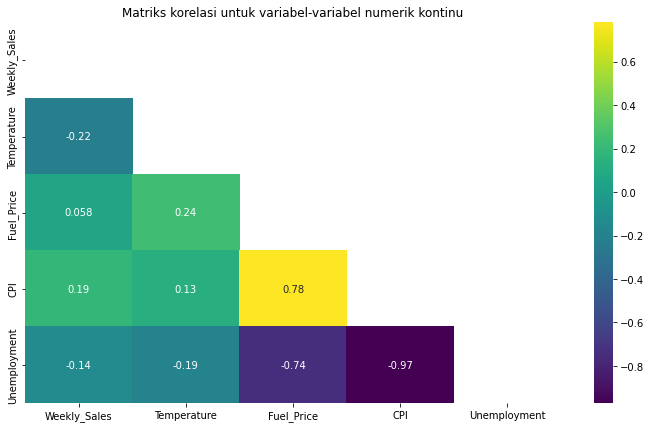

In [ ]:
df_continuous_a = df_type_a_agg[desc.loc[desc['vartype'] == 'Continuous'].index]
matrix = np.triu(df_continuous_a.corr())
plt.figure(figsize=(12,7))
sns.heatmap(df_continuous_a.corr(), annot=True, cmap='viridis', mask=matrix)
plt.title('Matriks korelasi untuk variabel-variabel numerik kontinu');

Weekly_Sales adalah variabel utama yang akan dijadikan target peramalan. Untuk itu, dengan adanya heatmap plot yang menunjukkan korelasi antar variabel numerik pada toko bertipe A di atas, keseluruhan variabel memiliki angka korelasi yang rendah terhadap Weekly_Sales. Oleh karena itu, variabel-variabel tersebut dianggap tidak berpengaruh terhadap perubahan panda variabel target (Weekly_Sales).

Sehingga, dataframe yang akan digunakan adalah

In [ ]:
df_date_agg_model_type_a = df[df['Type']=='A'].groupby('Date').mean()[['Weekly_Sales']]
df_date_agg_model_type_a.index.freq = 'W-FRI'
df_date_agg_model_type_a.head()

Weekly_Sales
Date                    
2010-02-05  27012.896027
2010-02-12  27251.480959
2010-02-19  26421.369726
2010-02-26  23746.820548
2010-03-05  25306.776376

#### Train Test Split

In [ ]:
train_a = df_date_agg_model_type_a.iloc[:130]
test_a = df_date_agg_model_type_a.iloc[130:]

### 5.2. Model Tipe B

##### Memilih Fitur

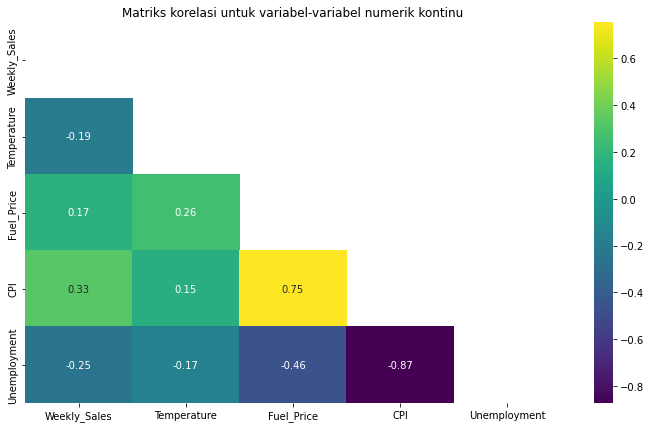

In [ ]:
df_continuous_b = df_type_b_agg[desc.loc[desc['vartype'] == 'Continuous'].index]
matrix = np.triu(df_continuous_b.corr())
plt.figure(figsize=(12,7))
sns.heatmap(df_continuous_b.corr(), annot=True, cmap='viridis', mask=matrix)
plt.title('Matriks korelasi untuk variabel-variabel numerik kontinu');

Dari hubungan fitur weekly_sales di atas, maka terlihata bahwa seluruh fitur numerik lainnya memiliki korelasi yang sangat lemah (mendekati 0). Oleh karena itu, fitur yang akan digunakan untuk membangun model forecasting hanyalah fitur weekly_sales itu sendiri.

Dataframe yang akan digunakan

In [ ]:
df_date_agg_model_type_b = df[df['Type'] == 'B'].groupby(['Date']).mean()[['Weekly_Sales']]
df_date_agg_model_type_b.head()

Weekly_Sales
Date                    
2010-02-05   6132.246614
2010-02-12   5678.718295
2010-02-19   5577.613538
2010-02-26   5292.863203
2010-03-05   5543.761811

##### Train Test Split

In [ ]:
train_b = df_date_agg_model_type_b.iloc[:130]
test_b = df_date_agg_model_type_b.iloc[130:]

## 5. Modelling

### 5.1. ARIMA

#### Modelling untuk Toko Tipe A

##### Dataframe untuk Toko Bertipe A

In [ ]:
df_date_agg_model_type_a.head()

Weekly_Sales
Date                    
2010-02-05  27012.896027
2010-02-12  27251.480959
2010-02-19  26421.369726
2010-02-26  23746.820548
2010-03-05  25306.776376

##### Plot Tipe A

In [ ]:
fig_main_ts_type_a = go.Figure()
fig_main_ts_type_a.add_traces(
    go.Line(x=df_date_agg_model_type_a.index, y = df_date_agg_model_type_a['Weekly_Sales'], name='Weekly Sales')
)

fig_main_ts_type_a.show()

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




##### Dekomposisi Data

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

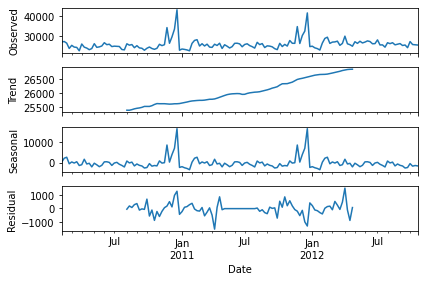

In [ ]:
decomp_type_a = seasonal_decompose(df_date_agg_model_type_a['Weekly_Sales'], model='add')
decomp_type_a.plot();

##### Cek Stasioner Data

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Terbukti kuat menolak null hypothesis")
        print("Tolak null hypothesis")
        print("Data telah stasioner")
    else:
        print("Terbukti lemah menolak null hypothesis")
        print("Gagal menolak ull hypothesis")
        print("Data tidak stasioner")

In [ ]:
adf_test(df_date_agg_model_type_a['Weekly_Sales'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -5.250390
p-value                   0.000007
# lags used               4.000000
# observations          138.000000
critical value (1%)      -3.478648
critical value (5%)      -2.882722
critical value (10%)     -2.578065
Terbukti kuat menolak null hypothesis
Tolak null hypothesis
Data telah stasioner


##### Memilih Order ARIMA dengan Plot ACF dan PACF

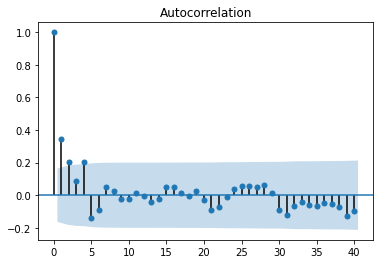

In [ ]:
plot_acf(df_date_agg_model_type_a['Weekly_Sales'], lags=40);

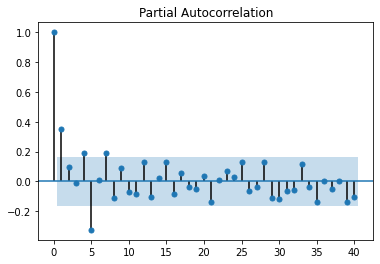

In [ ]:
plot_pacf(df_date_agg_model_type_a['Weekly_Sales'], lags=40);

##### Memilih Berberapa Order ARIMA dengan Grid Search (Auto Arima)

In [ ]:
from pmdarima import auto_arima

In [ ]:
auto_arima(df_date_agg_model_type_a['Weekly_Sales'], seasonal=False, trace= True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3316.049, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3222.621, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2687.443, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2677.605, Time=0.27 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2681.344, Time=0.24 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.40 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2669.060, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2667.664, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2671.246, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2666.327, Time=0.02 s

ARIMA(order=(1, 0, 0), scoring_args={}, suppress_warnings=True)

##### Model untuk Tipe A

In [ ]:
model_a = ARIMA(train_a['Weekly_Sales'], order=(1,0,0))

In [ ]:
start = len(train_a)
end = len(train_a) + len(test_a) - 1
results_a = model_a.fit()
predictions_a = results_a.predict(start, end).rename('ARIMA (1,0,0) Predictions')

In [ ]:
fig_test_pred_a = go.Figure()

fig_test_pred_a.add_trace(
    go.Line(x=test_a.index, y=test_a['Weekly_Sales'], name='Weekly Sales')
)

fig_test_pred_a.add_trace(
    go.Line(x=predictions_a.index, y=predictions_a, name='ARIMA (1,0,0) Predictions')
)

fig_test_pred_a.show()

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [ ]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [ ]:
test_a['Predictions'] = predictions_a

In [ ]:
mape_a_arima = mape(test_a['Weekly_Sales'], test_a['Predictions'])
print(mape_a_arima)

2.4889704905905083


##### Peramalan untuk 12 Minggu Berikutnya

In [ ]:
model_a = ARIMA(df_date_agg_model_type_a['Weekly_Sales'], order=(1,0,0))

In [ ]:
results_a = model_a.fit()

In [ ]:
fcast_a = results_a.predict(start=len(df_date_agg_model_type_a), end=len(df_date_agg_model_type_a)+13).rename('ARIMA (1,0,0) forecast')

In [ ]:
fig_fcast_type_a = go.Figure()

fig_fcast_type_a.add_trace(
    go.Line(y=df_date_agg_model_type_a['Weekly_Sales'], x = df_date_agg_model_type_a.index, name='Weekly Sales Type A')
    
)
fig_fcast_type_a.add_trace(
    go.Line(x = fcast_a.index, y = fcast_a, name='13 Weeks Forecast')
    
)
fig_fcast_type_a.show()

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




#### Modelling untuk Toko Tipe B

##### Dataframe untuk Toko Bertipe B

In [ ]:
df_date_agg_model_type_b.head()

Weekly_Sales
Date                    
2010-02-05   6132.246614
2010-02-12   5678.718295
2010-02-19   5577.613538
2010-02-26   5292.863203
2010-03-05   5543.761811

##### Plot Tipe B

In [ ]:
fig_main_ts_type_b = go.Figure()
fig_main_ts_type_b.add_traces(
    go.Line(x=df_date_agg_model_type_b.index, y = df_date_agg_model_type_b['Weekly_Sales'], name='Weekly Sales')
)

fig_main_ts_type_b.show()

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




##### Dekomposisi Data

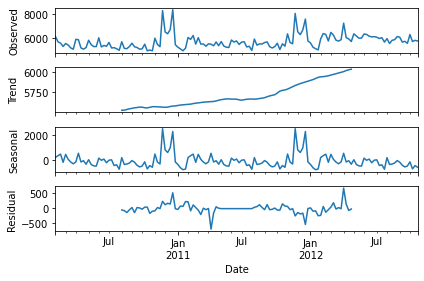

In [ ]:
decomp_type_b = seasonal_decompose(df_date_agg_model_type_b['Weekly_Sales'], model='add')
decomp_type_b.plot();

##### Cek Stasioner I

In [ ]:
adf_test(df_date_agg_model_type_b['Weekly_Sales'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -4.431573
p-value                   0.000261
# lags used               4.000000
# observations          138.000000
critical value (1%)      -3.478648
critical value (5%)      -2.882722
critical value (10%)     -2.578065
Terbukti kuat menolak null hypothesis
Tolak null hypothesis
Data telah stasioner


##### Memilih Order ARIMA dengan Plot ACF dan PACF

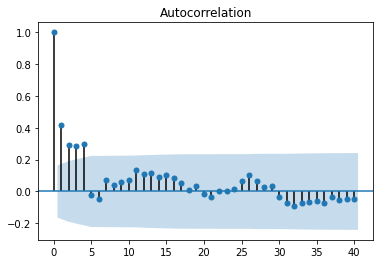

In [ ]:
plot_acf(df_date_agg_model_type_b['Weekly_Sales'], lags=40);

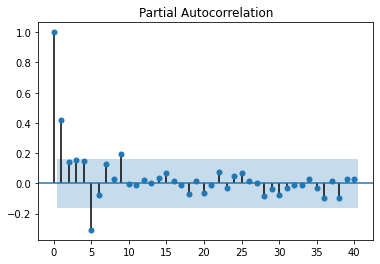

In [ ]:
plot_pacf(df_date_agg_model_type_b['Weekly_Sales'], lags=40);

##### Memilih Beberapa Order ARIMA dengan Grid Search (Auto ARIMA)

In [ ]:
auto_arima(df_date_agg_model_type_b['Weekly_Sales'], seasonal=False, trace= True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2207.127, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2244.005, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2222.607, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2203.935, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2242.009, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2202.008, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2196.740, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2220.606, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2197.509, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2196.207, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2199.269, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2205.1

ARIMA(order=(1, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

##### Diferensiasi Pertama

In [ ]:
from statsmodels.tsa.statespace.tools import diff
df_date_agg_model_type_b['Diff 1'] = diff(df_date_agg_model_type_b['Weekly_Sales'], k_diff=1)
df_date_agg_model_type_b.head()

Weekly_Sales      Diff 1
Date                                
2010-02-05   6132.246614         NaN
2010-02-12   5678.718295 -453.528320
2010-02-19   5577.613538 -101.104756
2010-02-26   5292.863203 -284.750335
2010-03-05   5543.761811  250.898608

##### Cek Stasioner II

In [ ]:
adf_test(df_date_agg_model_type_b['Diff 1'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -7.198992e+00
p-value                 2.392807e-10
# lags used             7.000000e+00
# observations          1.340000e+02
critical value (1%)    -3.480119e+00
critical value (5%)    -2.883362e+00
critical value (10%)   -2.578407e+00
Terbukti kuat menolak null hypothesis
Tolak null hypothesis
Data telah stasioner


##### Model untuk Tipe B

In [ ]:
model_b = ARIMA(train_b['Weekly_Sales'], order=(1,1,2))
model_b2 = ARIMA(train_b['Weekly_Sales'], order=(1,0,2))


In [ ]:
results_b = model_b.fit()
results_b2 = model_b2.fit()

In [ ]:
start = len(train_b)
end = len(train_b) + len(test_b) - 1

predictions_b = results_b.predict(start, end).rename('ARIMA (1,1,2) Predictions')
predictions_b2 = results_b2.predict(start, end).rename('ARIMA (1,0,2) Predictions')

In [ ]:
fig_test_pred_b = go.Figure()

fig_test_pred_b.add_trace(
    go.Line(x=test_b.index, y=test_b['Weekly_Sales'], name='Weekly Sales')
)

fig_test_pred_b.add_trace(
    go.Line(x=predictions_b.index, y=predictions_b, name='ARIMA (1,1,2) Predictions')
)
fig_test_pred_b.add_trace(
    go.Line(x=predictions_b2.index, y=predictions_b2, name='ARIMA (1,0,2) Predictions')
)
fig_test_pred_b.show()

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [ ]:
test_b['Predictions ARIMA(1,1,2)'] = predictions_b
test_b['Predictions ARIMA(1,0,2)'] = predictions_b2


In [ ]:
mape_b_arima112 = mape(test_b['Weekly_Sales'], test_b['Predictions ARIMA(1,1,2)'])

In [ ]:
mape_b_arima102 = mape(test_b['Weekly_Sales'], test_b['Predictions ARIMA(1,0,2)'])

##### Peramalan untuk 13 Minggu Berikutnya

In [ ]:
model_b = ARIMA(df_date_agg_model_type_b['Weekly_Sales'], order=(1,0,2))
model_b2 = ARIMA(df_date_agg_model_type_b['Weekly_Sales'], order=(1,1,2))

In [ ]:
results_b = model_b.fit()
results_b2 = model_b2.fit()

In [ ]:
fcast_b = results_b.predict(start=len(df_date_agg_model_type_b), end=len(df_date_agg_model_type_b)+13).rename('ARIMA (1,0,2) forecast')
fcast_b2 = results_b2.predict(start=len(df_date_agg_model_type_b), end=len(df_date_agg_model_type_b)+13).rename('ARIMA (1,1,2) forecast')

In [ ]:
fig_fcast_type_b = go.Figure()

fig_fcast_type_b.add_trace(
    go.Line(y=df_date_agg_model_type_b['Weekly_Sales'], x = df_date_agg_model_type_b.index, name='Weekly Sales Type B')
    
)
fig_fcast_type_b.add_trace(
    go.Line(x = fcast_b.index, y = fcast_b, name='13 Weeks Forecast ARIMA(1,0,2)')
    
)

fig_fcast_type_b.add_trace(
    go.Line(x = fcast_b2.index, y = fcast_b2, name='13 Weeks Forecast ARIMA(1,1,2)')
    
)
fig_fcast_type_b.show()

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.






### 5.2. Tes Holt-Winter

#### Toko Tipe A

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

##### Model Holt-Winter ExponentialSmoothing

In [ ]:
test_predictions_a_hw = ExponentialSmoothing(train_a['Weekly_Sales'], trend='add', seasonal='add', seasonal_periods=52).fit().forecast(13) 

##### Plot Train, Test, dan Prediction Data

In [ ]:
fig_test_pred_a_hw = go.Figure()

fig_test_pred_a_hw.add_trace(
    go.Line(x=test_a.index, y=test_a['Weekly_Sales'], name='Test Data')
)

fig_test_pred_a_hw.add_trace(
    go.Line(x=train_a.index, y=train_a['Weekly_Sales'], name='Train Data')
)
fig_test_pred_a_hw.add_trace(
    go.Line(x=test_predictions_a_hw.index, y=test_predictions_a_hw, name='Prediction')
)

fig_test_pred_a_hw.show()



/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




##### Evaluation Metrics (MAPE)

In [ ]:
mape_a_hw = mape(test_a['Weekly_Sales'], test_predictions_a_hw)
print(mape_a_hw)

2.536128813728418


##### Final Model untuk Peramalan pada Data yang Belum Diketahui (13 Minggu)

In [ ]:
forecast_predictions_a_hw = ExponentialSmoothing(df_date_agg_model_type_a['Weekly_Sales'], trend='add', seasonal='add', seasonal_periods=52).fit().forecast(12)

In [ ]:
fig_fcast_a_hw = go.Figure()

fig_fcast_a_hw.add_trace(
    go.Line(x=df_date_agg_model_type_a.index, y=df_date_agg_model_type_a['Weekly_Sales'], name='Weekly Sales')
)

fig_fcast_a_hw.add_trace(
    go.Line(x=forecast_predictions_a_hw.index, y=forecast_predictions_a_hw, name='Forecast for 12 Weeks')
)


fig_fcast_a_hw.show()



/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




#### Toko Tipe B

##### Model Holt-Winter ExponentialSmoothing

In [ ]:
test_predictions_b_hw = ExponentialSmoothing(train_b['Weekly_Sales'], trend='add', seasonal='add', seasonal_periods=52).fit().forecast(13) # 13, jumlah test set

##### Plot Train, Test, dan Prediction Data

In [ ]:
fig_test_pred_b_hw = go.Figure()

fig_test_pred_b_hw.add_trace(
    go.Line(x=test_b.index, y=test_b['Weekly_Sales'], name='Test Data')
)

fig_test_pred_b_hw.add_trace(
    go.Line(x=train_b.index, y=train_b['Weekly_Sales'], name='Train Data')
)
fig_test_pred_b_hw.add_trace(
    go.Line(x=test_predictions_b_hw.index, y=test_predictions_b_hw, name='Prediction')
)

fig_test_pred_b_hw.show()



/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




##### Evaluation Metrics (MAPE)

In [ ]:
mape_b_hw = mape(test_b['Weekly_Sales'], test_predictions_b_hw)
print(mape_b_hw)

4.817621060771172


##### Final Model untuk Peramalan pada Data yang Belum Diketahui (12 Minggu)

In [ ]:
forecast_predictions_b_hw = ExponentialSmoothing(df_date_agg_model_type_b['Weekly_Sales'], trend='add', seasonal='add', seasonal_periods=52).fit().forecast(12)

In [ ]:
fig_fcast_b_hw = go.Figure()

fig_fcast_b_hw.add_trace(
    go.Line(x=df_date_agg_model_type_b.index, y=df_date_agg_model_type_b['Weekly_Sales'], name='Weekly Sales')
)

fig_fcast_b_hw.add_trace(
    go.Line(x=forecast_predictions_b_hw.index, y=forecast_predictions_b_hw, name='Forecast for 12 Weeks')
)


fig_fcast_b_hw.show()



/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




### 5.3. SARIMAX


#### Tipe Toko A

##### Dataframe untuk Toko Bertipe A

In [ ]:
df_date_agg_model_type_a.head()

Weekly_Sales
Date                    
2010-02-05  27012.896027
2010-02-12  27251.480959
2010-02-19  26421.369726
2010-02-26  23746.820548
2010-03-05  25306.776376

##### Dekomposisi Data


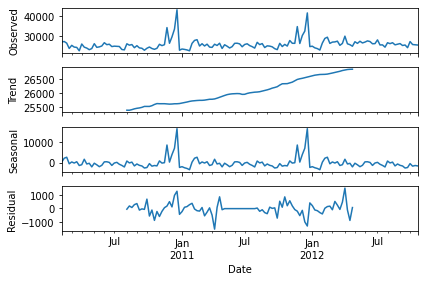

In [ ]:
seasonal_decompose(df_date_agg_model_type_a['Weekly_Sales'], model='add').plot();

##### Memilih Berberapa Order SARIMA dengan Auto Arima

In [ ]:
auto_arima(df_date_agg_model_type_a['Weekly_Sales'], seasonal=True, m=52, trace= True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=2682.446, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=2642.941, Time=4.35 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=3316.049, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=2666.327, Time=0.02 sec
 ARIMA(1,0,0)(2,0,0)[52] intercept   : AIC=inf, Time=40.51 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(2,0,1)[52] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(1,0,0)[52] intercept   : AIC=2684.083, Time=0.82 sec
 ARIMA(2,0,0)(1,0,0)[52] intercept   : AIC=2637.447, Time=4.30 sec
 ARIMA(2,0,0)(0,0,0)[52] intercept   : AIC=2667.044, Time=0.04 sec
 ARIMA(2,0,0)(2,0,0)[52] intercept   : AIC=2630.074, Time=21.18 sec
 ARIMA(2,0,0)(2,0,1)[52] intercept   : AIC=inf, Time

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  143
Model:             SARIMAX(1, 0, 1)x(2, 0, 0, 52)   Log Likelihood               -1248.776
Date:                            Wed, 29 Dec 2021   AIC                           2507.552
Time:                                    13:44:45   BIC                           2522.366
Sample:                                         0   HQIC                          2513.572
                                            - 143                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9979      0.005    208.995      0.000       0.989       1.007
ma.L1         -0.8765      0.048    -18.323      0.000      -0.970      -0.783
ar.S.L52       0.6899      0.136      5.078      0.000       0.424       0.956
ar.S.L104      0.2776      0.139      1.997      0.046       0.005       0.550
sigma2      8.388e+05   9.04e-08   9.28e+12      0.000    8.39e+05    8.39e+05
===================================================================================
Ljung-Box (Q):                       52.78   Jarque-Bera (JB):               211.18
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                             1.37
Prob(H) (two-sided):                  0.48   Kurtosis:                         8.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.61e+28. Standard errors may be unstable.
"""

##### Model untuk Tipe A

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
results_a_sarima = SARIMAX(train_a['Weekly_Sales'], order=(1,0,1), seasonal_order=(2,0,0,52)).fit()
predictions_a_sarima = results_a_sarima.predict(start, end, typ='levels').rename('SARIMA Predictions')

In [ ]:
fig_a_test_pred = go.Figure()
fig_a_test_pred.add_trace(
    go.Line(x = test_a['Weekly_Sales'].index, y = test_a['Weekly_Sales'], name = 'Test Data')
)
fig_a_test_pred.add_trace(
    go.Line(x = predictions_a_sarima.index, y = predictions_a_sarima, name = 'SARIMA(1,0,1)x(2,0,0,52)')
)

fig_a_test_pred.show()

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [ ]:
mape_a_sarima = mape(test_a['Weekly_Sales'], predictions_a_sarima)

##### Peramalan untuk 13 Minggu Berikutnya

In [ ]:
results_a_sarima = SARIMAX(df_date_agg_model_type_a['Weekly_Sales'],  order=(1,0,1), seasonal_order=(2,0,0,52)).fit()

In [ ]:
fcast_a_sarima = results_a_sarima.predict(start=len(df_date_agg_model_type_a), end=len(df_date_agg_model_type_a)+13, typ='levels').rename('Forecast for 13 Weeks')

In [ ]:
fig_fcast_a_sarima = go.Figure()
fig_fcast_a_sarima.add_trace(
    go.Line(x=df_date_agg_model_type_a.index, y=df_date_agg_model_type_a['Weekly_Sales'], name='Weekly Sales')
)
fig_fcast_a_sarima.add_trace(
    go.Line(x=fcast_a_sarima.index, y=fcast_a_sarima, name='Forecast for 13 Weeks')
)
fig_fcast_a_sarima.show()

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




#### Tipe Toko B

##### Dataframe untuk Toko Bertipe B

In [ ]:
df_date_agg_model_type_b[['Weekly_Sales']].head()

Weekly_Sales
Date                    
2010-02-05   6132.246614
2010-02-12   5678.718295
2010-02-19   5577.613538
2010-02-26   5292.863203
2010-03-05   5543.761811

##### Dekomposisi Data

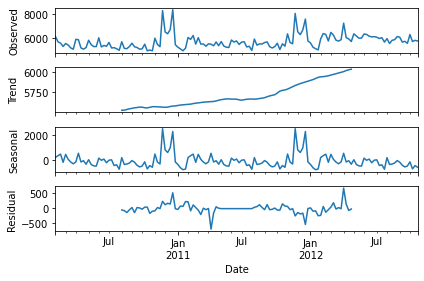

In [ ]:
seasonal_decompose(df_date_agg_model_type_b[['Weekly_Sales']]).plot();

##### Memilih Berberapa Order SARIMA dengan Auto Arima

In [ ]:
auto_arima(df_date_agg_model_type_b['Weekly_Sales'], seasonal=True, m=52, trace= True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=2244.005, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=inf, Time=5.53 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=2242.009, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AIC=inf, Time=3.22 sec
 ARIMA(0,1,0)(0,0,1)[52] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(1,0,1)[52] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=2222.607, Time=0.03 sec
 ARIMA(1,1,0)(0,0,1)[52] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,1,0)(1,0,1)[52] intercept   : AIC=inf, Time=nan sec
 ARIMA(2,1,0)(0,0,0)[52] intercept   : AIC=2210.794, Time=0.05 sec
 ARIMA(2,1,0)(1,0,0)[52] intercept   : AIC=inf, Time=5.64 sec
 ARIMA(2,1,0)(0,0,1)[52] intercept   : AIC=inf, Time=nan sec
 ARIMA(2,1,0)(1,0,1)[52] intercept   : AIC=inf, Time=nan sec
 ARIMA(3,1,0)(0

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  143
Model:               SARIMAX(5, 1, 1)   Log Likelihood               -1084.993
Date:                Wed, 29 Dec 2021   AIC                           2183.985
Time:                        13:47:03   BIC                           2204.676
Sample:                             0   HQIC                          2192.393
                                - 143                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3296      0.103      3.213      0.001       0.129       0.531
ar.L2          0.0765      0.100      0.767      0.443      -0.119       0.272
ar.L3          0.0927      0.075      1.236      0.216      -0.054       0.240
ar.L4          0.2087      0.057      3.684      0.000       0.098       0.320
ar.L5         -0.3051      0.075     -4.072      0.000      -0.452      -0.158
ma.L1         -0.9518      0.047    -20.088      0.000      -1.045      -0.859
sigma2      2.476e+05    1.5e+04     16.500      0.000    2.18e+05    2.77e+05
===================================================================================
Ljung-Box (Q):                       14.24   Jarque-Bera (JB):               801.34
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.47   Skew:                             2.55
Prob(H) (two-sided):                  0.01   Kurtosis:                        13.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##### Model untuk Tipe B

In [ ]:
results_b_sarima = SARIMAX(train_b['Weekly_Sales'], order=(5,1,1), seasonal_order=(0,0,0,52)).fit()
predictions_b_sarima = results_b_sarima.predict(start, end, typ='levels').rename('SARIMA Predictions')


In [ ]:
fig_b_test_pred = go.Figure()
fig_b_test_pred.add_trace(
    go.Line(x = test_b['Weekly_Sales'].index, y = test_b['Weekly_Sales'], name = 'Test Data')
)
fig_b_test_pred.add_trace(
    go.Line(x = predictions_b_sarima.index, y = predictions_b_sarima, name = 'SARIMA(5,1,1)x(0,0,0,52)')
)


fig_b_test_pred.show()

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [ ]:
mape_b_sarima = mape(test_b['Weekly_Sales'], predictions_b_sarima)

In [ ]:
mape_b_sarima

3.8022300944301506

##### Peramalan untuk 13 Minggu Berikutnya

In [ ]:
results_b_sarima = SARIMAX(df_date_agg_model_type_b['Weekly_Sales'],  order=(5,1,1), seasonal_order=(0,0,0,52)).fit()
fcast_b_sarima = results_b_sarima.predict(start=len(df_date_agg_model_type_b), end=len(df_date_agg_model_type_b)+13, typ='levels').rename('Forecast for 13 Weeks')

In [ ]:
fig_fcast_b_sarima = go.Figure()
fig_fcast_b_sarima.add_trace(
    go.Line(x=df_date_agg_model_type_b.index, y=df_date_agg_model_type_b['Weekly_Sales'], name='Weekly Sales')
)
fig_fcast_b_sarima.add_trace(
    go.Line(x=fcast_b_sarima.index, y=fcast_b_sarima, name='Forecast for 13 Weeks')
)
fig_fcast_b_sarima.show()

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




## 6. Models Evaluation

### 6.1. Evaluation Metrics

In [ ]:
mape_a = pd.DataFrame({'ARIMA(1,0,0)':mape_a_arima, 
              'Holt-Winter':mape_a_hw, 'SARIMA':mape_a_sarima}, index=['MAPE (%)']).T

mape_b = pd.DataFrame({'ARIMA(1,1,2)':mape_b_arima112, 
                       'ARIMA(1,0,2)':mape_b_arima102,
              'Holt-Winter':mape_b_hw, 'SARIMA':mape_b_sarima}, index=['MAPE (%)']).T

In [ ]:
mape_a

MAPE (%)
ARIMA(1,0,0)  2.488970
Holt-Winter   2.536129
SARIMA        1.882849

In [ ]:
mape_b

MAPE (%)
ARIMA(1,1,2)  99.411607
ARIMA(1,0,2)   2.976144
Holt-Winter    4.817621
SARIMA         3.802230

### 6.2. Full Evaluations

#### Type A

In [ ]:
subplot_titles = ('ARIMA (1,0,0)', 'ARIMA (1,0,0)', 'Holt-Winter Exponential Smoothing', 'Holt-Winter Exponential Smoothing', 'SARIMA(1,0,1)x(2,0,0,52)','SARIMA(1,0,1)x(2,0,0,52)')
fig_subplot_test_model = make_subplots(column_widths=[0.3, 0.7], rows=3, cols=2, subplot_titles=subplot_titles, shared_xaxes=True
                    )

#arima
fig_subplot_test_model.add_trace(
    go.Line(x=test_a.index, y=test_a['Weekly_Sales'], name='Test Data', legendgroup='Predictions',legendgrouptitle_text="Evaluation", marker_color = '#636EFA'), row=1, col=1
)
fig_subplot_test_model.add_trace(
   go.Scatter(
       x = ['2012-08-10'],
       y = [24500],
       mode = 'text',
       text = 'MAPE = {}%'.format(round(mape_a.iloc[0][0],2)), showlegend=False
   ), row=1, col=1
)

fig_subplot_test_model.add_trace(
    go.Line(x=predictions_a.index, y=predictions_a, name='Predictions', legendgroup='Predictions', marker_color = '#00CC96'), row=1, col=1
)


#hw
fig_subplot_test_model.add_trace(
    go.Line(x=test_a.index, y=test_a['Weekly_Sales'], name='Test Data', legendgroup='Predictions', marker_color = '#636EFA', showlegend=False), row=2, col=1
)
fig_subplot_test_model.add_trace(
   go.Scatter(
       x = ['2012-08-10'],
       y = [24500],
       mode = 'text',
       text = 'MAPE = {}%'.format(round(mape_a.iloc[1][0],2)), showlegend=False
   ), row=2, col=1
)

fig_subplot_test_model.add_trace(
    go.Line(x=test_predictions_a_hw.index, y=test_predictions_a_hw, name='Predictions', legendgroup='Predictions', marker_color = '#00CC96', showlegend=False), row=2, col=1
)


#sarima
fig_subplot_test_model.add_trace(
    go.Line(x = test_a['Weekly_Sales'].index, y = test_a['Weekly_Sales'], name = 'Test Data', legendgroup='Predictions', marker_color = '#636EFA', showlegend=False), row=3, col=1
)
fig_subplot_test_model.add_trace(
    go.Line(x = predictions_a_sarima.index, y = predictions_a_sarima, name = 'Predictions', legendgroup='Predictions', marker_color = '#00CC96', showlegend=False), row=3, col=1
)
fig_subplot_test_model.add_trace(
   go.Scatter(
       x = ['2012-08-10'],
       y = [24500],
       mode = 'text',
       text = 'MAPE = {}%'.format(round(mape_a.iloc[2][0],2)), showlegend=False
   ), row=3, col=1
)


##### FORECAST FOR 13 WEEKS

#arima
fig_subplot_test_model.add_trace(
    go.Line(y=df_date_agg_model_type_a['Weekly_Sales'], x = df_date_agg_model_type_a.index, name='Weekly Sales', marker_color='#EF553B', legendgroup='Forecast for 13 Weeks',legendgrouptitle_text="Forecast for 13 Weeks"), row=1,col=2
)
fig_subplot_test_model.add_trace(
    go.Line(x = fcast_a.index, y = fcast_a, name='Forecast', marker_color='#7F7F7F', legendgroup='Forecast for 13 Weeks'), row=1,col=2
    
)


#hw
fig_subplot_test_model.add_trace(
    go.Line(x=df_date_agg_model_type_a.index, y=df_date_agg_model_type_a['Weekly_Sales'], name='Weekly Sales', marker_color='#EF553B', legendgroup='Forecast for 13 Weeks', showlegend=False), row=2,col=2
)

fig_subplot_test_model.add_trace(
    go.Line(x=forecast_predictions_a_hw.index, y=forecast_predictions_a_hw, name='Forecast for 12 Weeks',marker_color='#7F7F7F', legendgroup='Forecast for 13 Weeks', showlegend=False), row=2,col=2
)


#sarima
fig_subplot_test_model.add_trace(
    go.Line(x=df_date_agg_model_type_a.index, y=df_date_agg_model_type_a['Weekly_Sales'], name='Weekly Sales', marker_color='#EF553B', legendgroup='Forecast for 13 Weeks', showlegend=False), row=3,col=2
)
fig_subplot_test_model.add_trace(
    go.Line(x=fcast_a_sarima.index, y=fcast_a_sarima, name='Forecast for 13 Weeks', marker_color='#7F7F7F', legendgroup='Forecast for 13 Weeks', showlegend=False), row=3,col=2
)





fig_subplot_test_model.update_layout(title_text="Type A: Predictions for Evaluation and Forecasts", height=600)
fig_subplot_test_model.show()


/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




Dari 3 model forecasting di atas, terlihat bahwa model yang terbaik untuk dapat dipilih adalah model SARIMA dengan order (1,0,1) dengan seasonal order (2,0,0,52). Model tersebut memiliki nilai evaluasi MAPE paling rendah, yaitu 1.88% dan berhasil memimik behavior penjualan periode sebelumnya. Untuk model ARIMA, hasil forecastingnya hanya berada di sekitar rata-rata periode sebelumnya dan tidak dapat memimik tren musiman.

#### Type B

In [ ]:
subplot_titles = (
    'ARIMA (1,1,2)', 
    'ARIMA (1,1,2)', 
    'ARIMA (1,0,2)', 
    'ARIMA (1,0,2)', 
    'Holt-Winter Exponential Smoothing',
    'Holt-Winter Exponential Smoothing', 
    'SARIMA(5,1,1)x(0,0,0,52)', 
    'SARIMA(5,1,1)x(0,0,0,52)'
)
fig_subplot_test_model_b = make_subplots(column_widths=[0.3, 0.7], rows=4, cols=2, subplot_titles=subplot_titles, shared_xaxes=True
                    )

#arima1
fig_subplot_test_model_b.add_trace(
    go.Line(x=test_b.index, y=test_b['Weekly_Sales'], name='Test Data', legendgroup='Predictions',legendgrouptitle_text="Evaluation", marker_color = '#636EFA'), row=1, col=1
)
fig_subplot_test_model_b.add_trace(
   go.Scatter(
       x = ['2012-08-24'],
       y = [3000],
       mode = 'text',
       text = 'MAPE = {}%'.format(round(mape_b.iloc[0][0],2)), showlegend=False
   ), row=1, col=1
)

fig_subplot_test_model_b.add_trace(
    go.Line(x=predictions_b.index, y=predictions_b, name='Predictions', legendgroup='Predictions', marker_color = '#00CC96'), row=1, col=1
)

#arima2
fig_subplot_test_model_b.add_trace(
    go.Line(x=test_b.index, y=test_b['Weekly_Sales'], showlegend=False, name='Test Data', legendgroup='Predictions',legendgrouptitle_text="on Test Data", marker_color = '#636EFA'), row=2, col=1
)
fig_subplot_test_model_b.add_trace(
   go.Scatter(
       x = ['2012-08-24'],
       y = [5250],
       mode = 'text',
       text = 'MAPE = {}%'.format(round(mape_b.iloc[1][0],2)), showlegend=False
   ), row=2, col=1
)

fig_subplot_test_model_b.add_trace(
    go.Line(x=predictions_b2.index, y=predictions_b2, name='Predictions', legendgroup='Predictions', marker_color = '#00CC96', showlegend=False), row=2, col=1
)



#hw
fig_subplot_test_model_b.add_trace(
    go.Line(x=test_b.index, y=test_b['Weekly_Sales'], name='Test Data', legendgroup='Predictions', marker_color = '#636EFA', showlegend=False), row=3, col=1
)
fig_subplot_test_model_b.add_trace(
   go.Scatter(
       x = ['2012-08-24'],
       y = [5000],
       mode = 'text',
       text = 'MAPE = {}%'.format(round(mape_b.iloc[2][0],2)), showlegend=False
   ), row=3, col=1
)

fig_subplot_test_model_b.add_trace(
    go.Line(x=test_predictions_b_hw.index, y=test_predictions_b_hw, name='Predictions', legendgroup='Predictions', marker_color = '#00CC96', showlegend=False), row=3, col=1
)


#sarima
fig_subplot_test_model_b.add_trace(
    go.Line(x = test_b['Weekly_Sales'].index, y = test_b['Weekly_Sales'], name = 'Test Data', legendgroup='Predictions', marker_color = '#636EFA', showlegend=False), row=4, col=1
)
fig_subplot_test_model_b.add_trace(
    go.Line(x = predictions_b_sarima.index, y = predictions_b_sarima, name = 'Predictions', legendgroup='Predictions', marker_color = '#00CC96', showlegend=False), row=4, col=1
)
fig_subplot_test_model_b.add_trace(
   go.Scatter(
       x = ['2012-08-24'],
       y = [5250],
       mode = 'text',
       text = 'MAPE = {}%'.format(round(mape_b.iloc[3][0],2)), showlegend=False
   ), row=4, col=1
)


##### FORECAST FOR 13 WEEKS

#arima2
fig_subplot_test_model_b.add_trace(
    go.Line(y=df_date_agg_model_type_b['Weekly_Sales'], x = df_date_agg_model_type_b.index, name='Weekly Sales', marker_color='#EF553B', legendgroup='Forecast for 13 Weeks',legendgrouptitle_text="Forecast for 13 Weeks"), row=1,col=2
)
fig_subplot_test_model_b.add_trace(
    go.Line(x = fcast_b2.index, y = fcast_b2, name='Forecast', marker_color='#7F7F7F', legendgroup='Forecast for 13 Weeks'), row=1,col=2
    
)

#arima2
fig_subplot_test_model_b.add_trace(
    go.Line(y=df_date_agg_model_type_b['Weekly_Sales'],showlegend=False, x = df_date_agg_model_type_b.index, name='Weekly Sales', marker_color='#EF553B', legendgroup='Forecast for 13 Weeks',legendgrouptitle_text="Forecast for 13 Weeks"), row=2,col=2
)
fig_subplot_test_model_b.add_trace(
    go.Line(x = fcast_b.index, y = fcast_b, name='Forecast', marker_color='#7F7F7F', legendgroup='Forecast for 13 Weeks',showlegend=False), row=2,col=2
    
)



#hw
fig_subplot_test_model_b.add_trace(
    go.Line(x=df_date_agg_model_type_b.index, y=df_date_agg_model_type_b['Weekly_Sales'], name='Weekly Sales', marker_color='#EF553B', legendgroup='Forecast for 13 Weeks', showlegend=False), row=3,col=2
)

fig_subplot_test_model_b.add_trace(
    go.Line(x=forecast_predictions_b_hw.index, y=forecast_predictions_b_hw,name='Forecast for 13 Weeks',marker_color='#7F7F7F', legendgroup='Forecast for 13 Weeks', showlegend=False), row=3,col=2
)


#sarima
fig_subplot_test_model_b.add_trace(
    go.Line(x=df_date_agg_model_type_b.index, y=df_date_agg_model_type_b['Weekly_Sales'], name='Weekly Sales', marker_color='#EF553B', legendgroup='Forecast for 13 Weeks', showlegend=False), row=4,col=2
)
fig_subplot_test_model_b.add_trace(
    go.Line(x=fcast_b_sarima.index, y=fcast_b_sarima, name='Forecast for 13 Weeks', marker_color='#7F7F7F', legendgroup='Forecast for 13 Weeks', showlegend=False), row=4,col=2
)





fig_subplot_test_model_b.update_layout(title_text="Type B: Predictions for Evaluation and Forecasts", height=800)
fig_subplot_test_model_b.show()


/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




Untuk di tipe B, akan dipilih model Holt-Winter Exponential Smoothing